In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

# `fishergw` tutorial

## Overview

This notebook is intended to provide an essential tutorial to the use of `fishergw`.

`fishergw` allows to compute Fisher matrices for two classes of signals:
- compact binary coalescences (CBC), and
- ringdown.

They are implemented in the `taylorf2` and `ringdown` subpackages, respectively, based on the symbolic manipulation package `sympy` for `Python`. Each subpackage has its own `waveform` and `fisher` modules, from which the main objects are imported.

Additionally, a `cosmology` subpackage provides basic routines to compute redshifts from distances and vice versa.
Finally, the `ringdown.utils` module contains several useful routines, e.g., to compute Kerr quasi-normal modes and to compute the final mass and spin of a binary black hole remnant.

## `taylorf2` tutorial

First, we import the main objects and we will go through them one by one.

In [2]:
from fishergw.taylorf2 import CompactObject, TaylorF2, Fisher

###  - `CompactObject`

`CompactObject` is a class that allows to define a compact object. A `CompactObject` is initialized by its 
- `mass` [$M_\odot$];
- dimensionless `spin`;
- dimensionless tidal deformability `Lamda` (optional, defaults to the black hole $\Lambda=0$);
- dimensionless spin-quadrupole moment `kappa` (optional, defaults to the black hole $\kappa=1$);
- `radius` [m] (optional, defaults to the black hole ISCO $R=6M$).

Here below we instantiate a black hole and a neutron star:

In [3]:
kwargs = {'mass':10,'spin':0.67}
obj1 = CompactObject(**kwargs)
print(obj1)
##
kwargs = {'mass':1.4,'spin':0.1,'Lamda':200,'radius':12e3}
obj2 = CompactObject(**kwargs)
print(obj2)

CompactObject
	mass:	10.00
	spin:	0.67
	kappa:	1.00
	Lamda:	0.00
	radius:	88603.75

CompactObject
	mass:	1.40
	spin:	0.10
	kappa:	1.00
	Lamda:	200.00
	radius:	12000.00



### - `TaylorF2`

From two compact objects, you can instantiate the waveform of a gravitational wave signal. The waveform is implemented in the form of a `TaylorF2` template. Beyond the two compact objects, you must aslo input:
- luminosity distance `d_L` [Mpc],
- time of coalescence `t_c` [s],
- phase of coalescence `phi_c`.

__Note__: the exact values of `t_c` and `phi_c`are irrelevant to the computation of the Fisher matrix, therefore you can omit them and they will both default to 0.

Let us instantiate a signal with the previously defined compact objects at 100 Mpc:

In [4]:
signal = TaylorF2(obj1,obj2,d_L=100)
signal

TaylorF2
	t_c:	0.00000
	phi_c:	0.00000
	M_c:	4421.77545
	eta:	0.10773
	chi_s:	0.38500
	chi_a:	0.28500
	Lamda_T:	0.59623
	delta_Lamda:	0.32107
	redshift:	0.00000
	kappa_s:	1.00000
	kappa_a:	0.00000

As you see, the `TaylorF2` object uses the provided arguments to instantiate the parameters of the waveform. In particular, note that 
- the chirp mass `M_c` is measured in meters;
- `Lamda_T` and `delta_Lamda` are the effective tidat parameters appearing at 5PN and 6PN order, respectively;
- `kappa_s` (`kappa_a`) is the (anti-)symmetric dimensionless spin-quadrupole moment.

__Note__: By default, `TaylorF2` ignores redshift and detector frame units are not rescaled. However, rescaling to the detector frame can be enabled through the `redshift=True` keyword argument. Redshift is derived from `d_L` usign $H_0=70\,{\rm Km/s/Mpc}$, $\Omega_{\rm matter}=0.3$ and $\Omega_{\Lambda}=0.7$.

In [5]:
signal = TaylorF2(obj1,obj2,d_L=100,redshift=True)
signal

/home/costantino/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


TaylorF2
	t_c:	0.00000
	phi_c:	0.00000
	M_c:	4523.21097
	eta:	0.10773
	chi_s:	0.38500
	chi_a:	0.28500
	Lamda_T:	0.59623
	delta_Lamda:	0.32107
	redshift:	0.02294
	kappa_s:	1.00000
	kappa_a:	0.00000

The value of the waveform 
$$
h(f)=A(f)e^{i\Phi(f)}=h(f)_{\rm real}+i\,h(f)_{\rm imag}
$$ 
at a given frequency (or at an array of frequencies) can be evaluated as simply as

In [6]:
f = 100
print(signal(100))

(-5.231292101943675e-26-9.210034295982889e-24j)


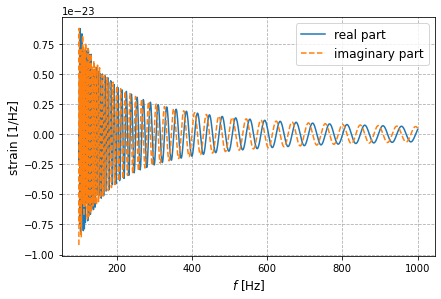

In [7]:
f = np.linspace(100,1000,1000)
plt.plot(f,signal(f).real,label='real part')
plt.plot(f,signal(f).imag,'--',label='imaginary part')
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend(fontsize=12)
plt.xlabel('$f$ [Hz]',fontsize=12)
plt.ylabel('strain [1/Hz]',fontsize=12)
plt.show()

__Note__: A note of caution about the normalization of the amplitude. `TaylorF2` follows the notation
$$
h(f)=\sqrt{\frac{5}{24}}\frac{M^{5/6}}{d_L}\frac{\sqrt{\eta}}{\pi^{2/3} f^{7/6}}e^{i\Phi(f)}\,.
$$
This notation ignores any contribution from the orientation angles in the pattern functions and the inclination angles. As will be explained later, the `Fisher` object deals with averaging over orientation and inclination angles. Choosing inclination and sky location is currently not supported.

### - `Fisher`

Once you have instatiated a `TaylorF2`, you can plug it into a `Fisher` object to compute the signal-to-noise ratio (SNR), uncertainties and correlations.

A `Fisher` also requires a list of `keys`, i.e., independent parameters w.r.t. which you differentiate in the Fisher matrix.

`fishergw` conforms to the standard practice of trating the amplitude $A$ as a free parameter. Therefore, only the phse $\Phi$ is differentiated.

The complete list of allowed `keys` is ``[t_c, phi_c, M_c, eta, chi_s, chi_a, Lamda_T, delta_Lamda]``. This is the default choice. However, you can also choose to restrict to a subset of it.

Finally, you can also specify a list of variables to be differentiated in log scale.

In [8]:
keys = ['t_c','phi_c','M_c','eta','Lamda_T','chi_s','chi_a']
logscale_keys = ['M_c','eta']
fisher = Fisher(signal,keys=keys,logscale_keys=logscale_keys)

We have not yet specified the PSD curve of the assumed detector. This can be provided manually thorugh the `load_asd` method, which takes in input the name to a text file `asd_name` containing two columns for the frequencies and the corresponding ASD values, respectively. In addition, you must provide the value `Qavg` of the angle-average normalization factor, defined such that the SNR, computed with the sensitivity
$$
S_h(f)=\frac{{\rm ASD}(f)}{\rm Q_{avg}}
$$
is the averaged SNR over the sky-location and inlination of the binary. For example, `Qavg=2/5` for an ordinary single L-shaped detector.

The `asd_name` will be first looked into the ``fishergw/detector/`` folder, then into the ``fishergw/detector/unofficial_asd/`` folder. Otherwise, ``asd_name`` must be the full path of the intended text file. As a shortcut, all the ASDs in the `fishergw/detector` folder can be accessed via the `detector` argument at the moment of instantiating the `Fisher`. Allowed detectors are `[aligo, etd, lisa, ce]`. The shortcut will automatically pick up the correct `Qavg` when loading the PSD. 

These below are equivalent ways of initializing the `Fisher` object

In [11]:
## method 1
keys = ['t_c','phi_c','M_c','eta','Lamda_T','chi_s','chi_a']
logscale_keys = ['M_c','eta']
fisher = Fisher(signal,keys=keys,logscale_keys=logscale_keys)
fisher.load_psd(asd_name='aligo_asd.txt',Qavg=2/5)
## method 2
keys = ['t_c','phi_c','M_c','eta','Lamda_T','chi_s','chi_a']
logscale_keys = ['M_c','eta']
fisher = Fisher(signal,keys=keys,logscale_keys=logscale_keys)
fisher.load_psd(asd_name='../fishergw/detector/aligo_asd.txt',\
                Qavg=2/5)
## method 3
keys = ['t_c','phi_c','M_c','eta','Lamda_T','chi_s','chi_a']
logscale_keys = ['M_c','eta']
fisher = Fisher(signal,keys=keys,logscale_keys=logscale_keys,\
                detector='aligo')
fisher

Fisher
	keys: ['t_c', 'phi_c', 'M_c', 'eta', 'Lamda_T', 'chi_s', 'chi_a']

	PSD:
		name: fishergw/detector/aligo_asd.txt
		Qavg: 0.4
		fmin: 5.00
		fmax: 5000.00

Plotting the PSD is as simple as:

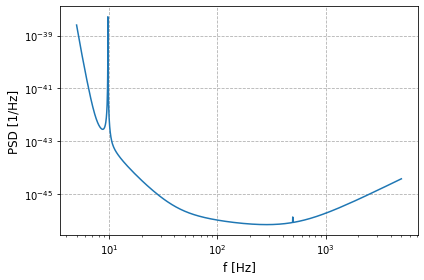

In [12]:
f = np.logspace(np.log10(5),np.log10(5e3),int(1e4))
psd = fisher.psd(f)
plt.plot(f,psd)
plt.loglog()
plt.xlabel('f [Hz]',fontsize=12)
plt.ylabel('PSD [1/Hz]',fontsize=12)
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

As you see, after loading the PSD, the `Fisher` instantiated also default values for `fmin` and `fmax`, i.e., minimum and maximum frequencies that will be used in the integrals over the frequency domain. However, it is often preferred to truncate the integral at the maximum frequency of validity of the waveform approximant. In the case of the `TaylorF2` approximant, this is approximately the ISCO frequency
$$
f_{\rm ISCO}=\left(6^{3/2}\pi M\right)^{-1}\,.
$$
The `TaylorF2` object contains an `isco` method to compute the ISCO frequency:

In [13]:
fmax = signal.isco(mode='static')
fmax

377.04059342895533

The `static` mode argument refers to the fact that the above formula for the ISCO frequency is exact for a _static_ Schwarzschild black hole with mass $M$. Other options are also available:
- `contact` computes the contact frequency according to
$$
f_{\rm max} = \frac{M^{1/2}}{\pi\,(R_1+R_2)^{3/2}}
$$
where, for black holes, the ISCO radius $R_{1,2}=6M_{1,2}$ is assumed;
- `Kerr` computes the ISCO with self-force and spin corrections.

You might also want to integrate from a different lower cutoff. For space based detectors such as LISA, it is common to fix the minimum frequency by requiring that the signal is observed for a fixed number of years. This can be obtained through the method `start_frequency_from_obs_time`:

In [14]:
obs_time = 5 ## years
signal.start_frequency_from_obs_time(obs_time)

0.06338528192311146

After choosing `fmin` and `fmax`, we are now ready to compute the SNR and the Fisher matrix.

In [15]:
fmin = 10
fmax = signal.isco(mode='static')
snr = fisher.snr(fmin,fmax,nbins=1e4)
snr

27.558699899174364

In [16]:
fisher_matrix = fisher.fisher_matrix(fmin,fmax,nbins=1e4)

In order to obtain the uncertainties $\sigma_i$ on each parameter in `keys`, you simply call the method `sigma1d`:

In [17]:
sigmas = fisher.sigma1d(fisher_matrix)
sigmas

{'t_c': 0.06516477997808368,
 'phi_c': 87.94379826465509,
 'M_c': 0.003237340706362628,
 'eta': 0.9593343435862528,
 'Lamda_T': 334.8108494966283,
 'chi_s': 1.8029099245665612,
 'chi_a': 2.1819496975023975}

From the above dictionary, we see that the uncertainties over the spins are large and, most importantly, exceed the physical allowed values. This can be alleviated by a suitable choice of priors. In particular, Fisher matrices easily allow to impose Gaussian priors. Here below, we demonstrate this by imposing Gaussian priors over `chi_s` and `chi_a` with width $0.1$:

In [18]:
priors = {'chi_s':0.1,'chi_a':0.1}
fisher_matrix = fisher.fisher_matrix(fmin,fmax,nbins=1e4,\
                                     priors=priors)
sigmas = fisher.sigma1d(fisher_matrix)
sigmas

{'t_c': 0.034388185242263725,
 'phi_c': 57.34438421443949,
 'M_c': 0.002368736222664972,
 'eta': 0.614353872893017,
 'Lamda_T': 134.19836648170394,
 'chi_s': 0.06512724209708304,
 'chi_a': 0.07787568608705342}

Finally, we demonstrate how to sample from the covariance matrix:

In [19]:
covariance_matrix = fisher.covariance_matrix(fisher_matrix)
samples = fisher.sample(covariance_matrix,nsamples=1e5)

From the plot below, we see the limitations inherent to a Fisher matrix approach. Indeed, the variable `Lamda_T` has an uncertainty large enough that negative values are also sampled. However, one can always impose an hard prior _a posteriori_ by restricting to samples with $\Lambda_T>0$.

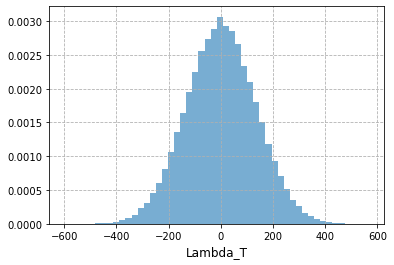

In [20]:
i = keys.index('Lamda_T')
x = samples[i]
plt.hist(x,density=True,bins=50,alpha=0.6)
plt.xlabel('Lambda_T',fontsize=12)
plt.grid(linestyle='--')
plt.show()

We can inspect the correlation matrix. For example, we discover (expectedly) that $\chi_s$ and $\chi_a$ are strongly anti-correlated.

In [21]:
correlation_matrix = fisher.correlation_matrix(fisher_matrix)
correlation_matrix

matrix([[ 1.        ,  0.99980771,  0.99925239, -0.99909192,  0.98033613,
          0.15389893,  0.20042539],
        [ 0.99980771,  1.        ,  0.99953618, -0.9994977 ,  0.97771078,
          0.16945302,  0.1846594 ],
        [ 0.99925239,  0.99953618,  1.        , -0.99834668,  0.97964318,
          0.17820617,  0.1768995 ],
        [-0.99909192, -0.9994977 , -0.99834668,  1.        , -0.97150102,
         -0.16714164, -0.18524759],
        [ 0.98033613,  0.97771078,  0.97964318, -0.97150102,  1.        ,
          0.13043083,  0.22414791],
        [ 0.15389893,  0.16945302,  0.17820617, -0.16714164,  0.13043083,
          1.        , -0.93609837],
        [ 0.20042539,  0.1846594 ,  0.1768995 , -0.18524759,  0.22414791,
         -0.93609837,  1.        ]])

## `ringdown` tutorial

In [23]:
from fishergw.ringdown import RingdownMultimode, Fisher
from fishergw.ringdown.utils import final_mass, final_spin, ringdown_absolute_amplitudes, qnm_Kerr
from fishergw.cosmology import redshift_from_distance

Ringdown is defined as a superimposition of damped sinusoids. Each sinusoid is determined by the frequency, the damping time, the amplitude and the phase, according to
$$
h_{lmn}(t)=A_{lmn}e^{-t/\tau_{lmn}}e^{-i(\omega_{lmn}t+\phi_{lmn})}\,.
$$
The couple $(l,m)$ indicate the angular and azimuthal number, while $n$ is the overtone number.

We choose to order the series of sinusoids in _blocks_ indicized by $(l,m)$, with each block containing attributes (`f0`, `f1`, ...) for the ($n=0$, $n=1$, ...) frequencies, and similarly for the other parameters. This is because, in the Fihser formalism, different _blocks_ have vanishing scalar product _when averaged over sky orientation_. Therefore, the Fisher matrix becomes block diagonal, thus reducing the computational cost. We stress however that, in the more general case of fixed sky location, the _blocks_ will have nonvanishing correlations. Here, since we restrict to angle averaged configurations, block diagonalness is a justified assumption.

### Ringdown parameters

The ringdown parameters are physically determined as functions of the binary parameters.
- The `final_mass` and `final_spin` functions return the final mass and spins of a black hole remnant, resulting from a binary black hole coalescence.
- `qnm_Kerr` returns the frequencies (in Hz) and damping times (in secs) of the Kerr spectrum. The default method is `interp`, which interpolates numerical tables of QNMs.
- `ringdown_absolute_amplitudes` returns the amplitude of a given mode.

__Note__: that absolute amplitudes depend on the extrinsic parameters. Here we only incorporate the dependence on the luminosity distance `d_L`, while the dependence on sky orientation and inclination is addressed later. If you are only interested in amplitudes relative to the fundamental $A_{220}$, you can instead use `ringdown_relative_amplitudes`.

All these functions are implemented in the `fishergw/ringdown/utils` module.

__Note__: it is assumed that masses, which set the legth and time scales, are already redshifted, i.e., they are provided in the detector frame. In alternative, you can compute the `final_mass` in the source frame and rescale it by $(1+z)$ before computing the QNMs. See below for the usage of the `cosmology` subpackage to compute the redshift $z$.

Here below we initialize a ringdown signal with _detector frame_ masses and spins similar to GW150914, but luminosity distance adjusted to give ${\rm SNR}\approx30$.

In [24]:
mass_1, mass_2 = 39, 32
spin_1, spin_2 = 0, 0
mass_f = final_mass(mass_1,mass_2,spin_1,spin_2)
spin_f = final_spin(mass_1,mass_2,spin_1,spin_2)
luminosity_distance = 80
mass_f, spin_f

(67.62936084454188, 0.6810220508579976)

In [25]:
## usage of `qnm_Kerr`
mode = (2,2,0)
f, tau = qnm_Kerr(mass_f,spin_f,mode,method='interp')
f, tau

(250.53591082029922, 0.004088621439364739)

In [27]:
## usage of `ringdown_absolute_amplitudes`
mass_ratio = mass_1/mass_2
ringdown_absolute_amplitudes(mass_f,mass_ratio,\
                             spin_1,spin_2,\
                             luminosity_distance,mode=(2,2,0))

8.653744309043299e-21

### Ringdown without overtones

We first address the case of two modes with different $(l,m)$, therefore no overtones are present. We initialize 2-dimensional lists corresponding to the `modes`, the frequencies `freqs`, the damping times `taus`, the amplitudes `amps` and the phases `phis`.

Because no phenomenological fit is implemented for the phases, we sample them randomly. However, note that phases have little correlations with the other parametres, therefore you can also fix them to 0 to help the reproducibility of the code.

In [28]:
modes = [(2,2,0),(3,3,0)]
freqs = []
taus = []
amps = []
phis = [np.random.uniform(0,np.pi*2) for i in range(len(modes))]
for mode in modes:
    f, tau = qnm_Kerr(mass_f,spin_f,mode)
    A = ringdown_absolute_amplitudes(mass_f,mass_1/mass_2,\
                                     spin_1,spin_2,d_L,mode)
    freqs.append(f)
    taus.append(tau)
    amps.append(A)

Then, we use the above lists to instantiate a multimode ringdown signal.

In [29]:
signal = RingdownMultimode(modes,freqs,taus,amps,phis)
print(signal)

RingdownMultimode
sorted modes:
	(2, 2, 0)	
	(3, 3, 0)	



To access a _block_, you can just call the corresponding $(l,m)$ element of the signal. Note, in particular, that amplitudes are stored in log10 scale. Correspondingly, amplitudes are assumed to be sampled uniformily in log scales in the Fisher matrix.

In [30]:
print(signal[2,2])
print(signal[3,3])

RingdownLM(lm=(2, 2))
mode0:	(2, 2, 0)
	f0:	250.53591082029922
	tau0:	0.004088621439364739
	logA0:	-20.062795940985236
	phi0:	0.5954120332007339

RingdownLM(lm=(3, 3))
mode0:	(3, 3, 0)
	f0:	397.2758912162464
	tau0:	0.0039820909314697995
	logA0:	-21.324887542333386
	phi0:	2.904069048837475



Evaluating the signal at a given frequency returns the plus and cross polarizations, which are defined by projecting $h_{lmn}$ along the spherical harmonics $\mathcal{Y}^{\pm}_{lm}(\iota)$, where $\iota$ is the orientation angle. We average the spherical harmonics over $\iota$.

Note that the averages differ for each $(l,m)$. This is the reason why (differently from the `taylorf2` subpackage) we implement averaging over inlcination directly in the signal, while leaving to the definition of the PSD only the average over sky position.

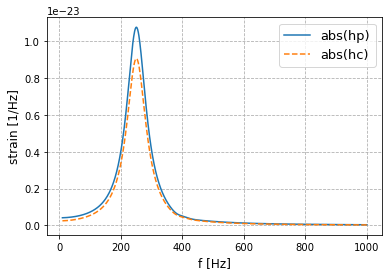

In [31]:
f = np.linspace(10,1000,1000)
hp, hc = signal(f)
plt.plot(f,np.abs(hp),label='abs(hp)')
plt.plot(f,np.abs(hc),'--',label='abs(hc)')
plt.grid(linestyle='--')
plt.legend(fontsize=13)
plt.xlabel('f [Hz]',fontsize=12)
plt.ylabel('strain [1/Hz]',fontsize=12)
plt.show()

The instantiation of a `Fihser` object proceeds exactly as in the `taylorf2` case. The only difference is that the angle-averaging factor `Qavg` only accounts for sky position. For example, in the case of a single L-shaped detector, `Qavg` is $1/\sqrt{5}$ instead of $2/5$.

In [32]:
fisher = Fisher(signal,detector='aligo')
fisher

Fisher
	PSD:
		name: fishergw/detector/aligo_asd.txt
		Qavg: 0.4472135954999579
		fmin: 5.00
		fmax: 5000.00

In [33]:
snr = fisher.snr(nbins=1e4)
print('snr:\t',snr)

snr:	 29.279799673848185


Because the Fisher matrix is block diagonal, we choose to represent it as a dictionary whose keys are the block labels $(l,m)$ and whose values are the actual blocks of the matrix. You see that each block has shape (4,4), corresponding to the four independent parameters (`f`, `tau`, `log10A` and `phi`, respectively) for each $(l,m)$ block.

In [34]:
fisher_matrix = fisher.fisher_matrix(nbins=1e4)
fisher_matrix

{(2,
  2): array([[ 2.81376179e-01, -3.38148829e+00,  5.10939451e-01,
          9.73130144e-03],
        [-3.38148829e+00,  2.55627272e+07,  2.44916777e+05,
          3.02481102e+02],
        [ 5.10939451e-01,  2.44916777e+05,  4.53276008e+03,
         -6.57660680e+00],
        [ 9.73130144e-03,  3.02481102e+02, -6.57660680e+00,
          8.52650162e+02]]),
 (3,
  3): array([[ 7.41517525e-04, -3.67438516e-03, -2.64783137e-03,
         -8.87694025e-06],
        [-3.67438516e-03,  7.46829856e+04,  6.89005259e+02,
         -3.70540231e-01],
        [-2.64783137e-03,  6.89005259e+02,  1.25925287e+01,
          7.23086985e-03],
        [-8.87694025e-06, -3.70540231e-01,  7.23086985e-03,
          2.36288692e+00]])}

The one-dimensional uncertainties are represented as a dictionary, whose keys are the $(l,m,n)$ modes and whose values are the uncertainties for, respectively, `f`, `tau`, `log10A` and `phi`.

In [36]:
sigmas = fisher.sigma1d(fisher_matrix)
sigmas

{(2, 2, 0): [1.885649851111738,
  0.0002848399952608475,
  0.02139285925261816,
  0.03424727829408528],
 (3, 3, 0): [36.75026250569854,
  0.005201801999928493,
  0.4007480693299972,
  0.6505495394224017]}

Having in mind spectroscopical purposes, it might be convenient to display percentual uncertainties in frequencies and damping times.

In [37]:
for mode,val in sigmas.items():
    i = modes.index(mode)
    print(mode,val[0]/freqs[i]*100,val[1]/taus[i]*100)

(2, 2, 0) 0.7526465347573466 6.966651216922247
(3, 3, 0) 9.250564486354527 130.62991502327387


We see that `tau` has a large uncertainty for the subdominant mode. This is, in part, a spurious effect of the Fisher formalism. Indeed, let us sample `tau` from the covariance matrix of the subdominant mode. We see that the distribution extends up to negative values of `tau`, which is an unphysical region.

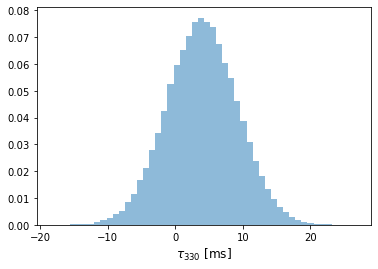

In [39]:
lm = (3,3)
covariance_matrix = fisher.covariance_matrix(fisher_matrix[lm])
samples = fisher.sample(lm,covariance_matrix,nsamples=1e5)
i = signal[lm].keys.index('tau0')
plt.hist(samples[i]*1000,bins=50,density=True,alpha=0.5)
plt.xlabel('$\\tau_{330}$ [ms]',fontsize=12)
plt.show()

In a realistic situation, one has prior knowledge about the mass and spin of the remnant, e.g., from a IMR analysis or from a ringdown analysis in which $M$ and $\chi$ are sampled instead of the QNM spectrum. Therefore, the values of the subdominant modes can be constrained under the assumption that the spectrum does not deviate much from the Kerr type. To mimic this, we impose a Gaussian prior on $\tau_{330}$ such that the standard deviation is 30% of the injected value. We plot the prior alongside the posterior, to highlight that imposing such restrictive priors can lead the posterior to simply reproduce the prior. Hence, one should take this operation with great care and decide case by case wether it is appropriate. For example, it might not be appropriate for estimating prospects of black hole spectroscopy, where the Kerr hypothesis shall not be assumed to inform the priors.

In [41]:
lm = (3,3)
fisher_matrix = fisher.fisher_matrix(nbins=1e4)
sigma_tau = taus[1]*0.3
priors = np.diag([0,1/(sigma_tau)**2,0,0])
fisher_matrix[lm] += priors
covariance_matrix = fisher.covariance_matrix(fisher_matrix[lm])
samples = fisher.sample(lm,covariance_matrix,nsamples=1e5)

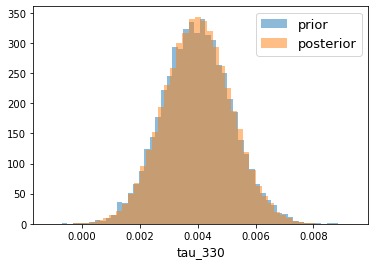

In [42]:
x = np.random.normal(taus[1],sigma_tau,int(1e4))
plt.hist(x,bins=50,density=True,alpha=0.5,label='prior')
i = signal[lm].keys.index('tau0')
plt.hist(samples[i],bins=50,density=True,alpha=0.5,label='posterior')
plt.legend(fontsize=13)
plt.xlabel('tau_330',fontsize=12)
plt.show()

The imposition of such a prior improves the recovery of the amplitude of the subdominant mode. This is because amplitude and damping times are strictly correlated. Here we display the correlation when no prior is imposed:

In [43]:
fisher_matrix = fisher.fisher_matrix(nbins=1e4)
lm = (3,3)
correlation_matrix = fisher.correlation_matrix(fisher_matrix[lm])
correlation_matrix

matrix([[ 1.00000000e+00, -2.69732982e-02,  3.84394710e-02,
          1.05941889e-04],
        [-2.69732982e-02,  1.00000000e+00, -7.10741005e-01,
          2.58801519e-03],
        [ 3.84394710e-02, -7.10741005e-01,  1.00000000e+00,
         -2.76816492e-03],
        [ 1.05941889e-04,  2.58801519e-03, -2.76816492e-03,
          1.00000000e+00]])

### Ringdown with overtones

We repeat the previous steps with the first overtone (2,2,1) instead of the (3,3,0) mode. We will therefore avoid repetitions and only comment when the differences are relevant.

In [44]:
mass_1, mass_2 = 39, 32
spin_1, spin_2 = 0, 0
mass_f = final_mass(mass_1,mass_2,spin_1,spin_2)
spin_f = final_spin(mass_1,mass_2,spin_1,spin_2)
d_L = 80
mass_f, spin_f

(67.62936084454188, 0.6810220508579976)

We change the default fitting `method` for the amplitudes, because `method=2` is the only one allowing for overtones.

In [46]:
modes = [(2,2,0),(2,2,1)]
freqs = []
taus = []
amps = []
phis = [0,0]#np.random.uniform(0,np.pi*2) for i in range(len(modes))]
for mode in modes:
    f,tau = qnm_Kerr(mass_f,spin_f,mode)
    A = ringdown_absolute_amplitudes(mass_f,mass_1/mass_2,\
                                     spin_1,spin_2,\
                                     luminosity_distance,\
                                     mode,method=2)
    freqs.append(f)
    taus.append(tau)
    amps.append(A)

Now, the signal has only one block, i.e., the (2,2) block.

In [47]:
signal = RingdownMultimode(modes,freqs,taus,amps,phis)
print(signal[2,2])

RingdownLM(lm=(2, 2))
mode0:	(2, 2, 0)
	f0:	250.53591082029922
	tau0:	0.004088621439364739
	logA0:	-20.062795940985236
	phi0:	0
mode1:	(2, 2, 1)
	f1:	244.80091647634686
	tau1:	0.0013519012596347692
	logA1:	-20.33291345365817
	phi1:	0



Correspondingly, the Fisher matrix has shape (8,8)

In [48]:
fisher = Fisher(signal,detector='aligo')
fisher_matrix = fisher.fisher_matrix(nbins=1e4)
fisher_matrix[2,2].shape

(8, 8)

In [50]:
fisher

Fisher
	PSD:
		name: fishergw/detector/aligo_asd.txt
		Qavg: 0.4472135954999579
		fmin: 5.00
		fmax: 5000.00

As shown below, because of the low SNR, the uncertanty over $\tau_{221}$ is large and leads to sample unphysical values. As already mentioned in the previous section, this is partly an artifact of the Fisher matrix and should be considered carefully when using the reported uncertainties to draw prospects about, e.g., black hole spectroscopy.

Notice also that, because of correlations between the fundamental mode and its overtone, the uncertainty on $\tau_{220}$ is much larger than the case where the subdominant mode is an angular mode.

In [51]:
snr = fisher.snr()
print('snr:\t',snr)
print('\nabsolute uncertainties:')
sigmas = fisher.sigma1d(fisher_matrix)
sigmas

snr:	 37.25223536945832

absolute uncertainties:


{(2, 2, 0): [2.533850816448629,
  0.0011575561957582316,
  0.2574446726800758,
  0.07161773036683525],
 (2, 2, 1): [28.86263552031098,
  0.001341040025084951,
  0.44070134044663406,
  0.24285144766594735]}

In [53]:
print('relative uncertainties:\n')
for mode,val in sigmas.items():
    i = modes.index(mode)
    print(mode,val[0]/freqs[i]*100,val[1]/taus[i]*100)

relative uncertainties:

(2, 2, 0) 1.011372305132765 28.311650098329583
(2, 2, 1) 11.790248147661549 99.1965955743874


## `cosmology`

The `cosmology` subpackage contains two routines to compute redshifts from luminosity distancies, according to $H_0=70\,{\rm Km/s/Mpc}$, $\Omega_{\rm matter}=0.3$ and $\Omega_{\Lambda}=0.7$.

In [54]:
from fishergw.cosmology import distance_from_redshift,\
    redshift_from_distance

In [58]:
luminosity_distance = 100
print('d_L injected: ',luminosity_distance)
z = redshift_from_distance(luminosity_distance)
print('redshift from d_L: ',z)
print('double check d_L from redshift: ',distance_from_redshift(z))

d_L injected:  100
redshift from d_L:  0.022939997033568315
double check d_L from redshift:  99.97880084679043


## Black hole spectroscopy

In this section we aare going to use routines from the `ringdown` subpackage to study prospects for black hole spectroscopy.

First, we define a signal containing the dominant (2,2,0) mode, the (3,3,0) angular mode and the (2,2,1) overtone.

Masses and spins are chosen to mimic a GW150914-like event, while the Fisher matrix is renormalized to an SNR of $\approx 100$ with the ET-D detector.

In [59]:
#from scipy.interpolate import interp2d
#from scipy.stats import gaussian_kde
#from scipy.integrate import simps, dblquad

from fishergw.ringdown import RingdownMultimode, Fisher
from fishergw.ringdown.utils import final_spin, qnm_Kerr,\
    ringdown_absolute_amplitudes

In [60]:
mass_f = 67
mass_ratio = 1.4
spin1, spin2 = 0, 0
spin_f = final_spin(mass_ratio,1,spin1,spin2)
print('final_spin: ',spin_f)
target_snr = 100
luminosity_distance = 100

final_spin:  0.6707536550605686


In [61]:
modes = [(2,2,0),(3,3,0),(2,2,1)]
freqs = []
taus = []
amps = []
## fixed to 0 for reproducibility
phis = [0 for i in range(len(modes))]
for mode in modes:
    f, tau = qnm_Kerr(mass_f,spin_f,mode)
    freqs.append(f)
    taus.append(tau)
    amp = ringdown_absolute_amplitudes(mass_f,mass_ratio,\
                            spin1,spin2,luminosity_distance,\
                                       mode,method=2)
    amps.append(amp)
## define signal
signal = RingdownMultimode(modes,freqs,taus,amps,phis)

In [62]:
fisher = Fisher(signal,detector='etd')
snr = fisher.snr()
scale = target_snr/snr

We compute the Fisher matrix and the relative percentage errors to know which modes are best constrained and, therefore, what is the best combination of modes that can constrain the deviation of the signal from a Kerr spectrum.

In [63]:
fisher_matrix = fisher.fisher_matrix()
for v in fisher_matrix.values():
    v *= scale**2
sigmas = fisher.sigma1d(fisher_matrix)
for k,v in sigmas.items():
    i = modes.index(k)
    print(k,v[0]/freqs[i]*100,v[1]/taus[i]*100)

(2, 2, 0) 0.38117407712959683 10.542044665579157
(2, 2, 1) 4.619629404481549 38.29426166861853
(3, 3, 0) 2.0962317640285657 28.538975084614176


### Resolvability

We see that frequencies are much better contrained than damping times, as it is usually expected from BBH ringdowns. Before proceeding to spectroscopy, one must ask wether modes are mutually distinguishable or, on the contrary, there is ambiguity between the modes. A useful criterion is the __Raileygh resolvability__: two modes are distiguishable if the peaks of their frequencies (or damping times) are separated by more than a standard deviation
$$
\frac{|f_1-f_2|}{{\rm max}(\sigma_{f_1},\sigma_{f_2})}\geq1
$$
or
$$
\frac{|\tau_1-\tau_2|}{{\rm max}(\sigma_{\tau_1},\sigma_{\tau_2})}\geq1
$$

Here below we show that:
- the two angular modes can be distinguished from the frequencies: this is because their damping times are similar in magnitude and have large uncertainties;
- the dominant angular mode (2,2,0) and its overtone (2,2,1) can be distinguished from the damping times: this is because their frequencies are too closely spaced while damping times are distinct enough to compensate for their larger uncertainties.
- (2,2,1) and (3,3,0) are distinguishable in both frequencies and damping times. Therefore, this signal allows to perform black hole spectroscopy unambigously.

In [64]:
## frequencies
mode1, mode2 = (2,2,0), (3,3,0)
i,j = modes.index(mode1), modes.index(mode2)
s1, s2 = sigmas[mode1][0], sigmas[mode2][0]
f1, f2 = freqs[i], freqs[j]
criterion_f = abs(f1-f2)/max(s1,s2)
## damping times
s1, s2 = sigmas[mode1][1], sigmas[mode2][1]
tau1, tau2 = taus[i], taus[j]
criterion_tau = abs(tau1-tau2)/max(s1,s2)
print(criterion_f,criterion_tau)

17.6360779635466 0.09596166913288026


In [65]:
## frequencies
mode1, mode2 = (2,2,0), (2,2,1)
i,j = modes.index(mode1), modes.index(mode2)
s1, s2 = sigmas[mode1][0], sigmas[mode2][0]
f1, f2 = freqs[i], freqs[j]
criterion_f = abs(f1-f2)/max(s1,s2)
## damping times
s1, s2 = sigmas[mode1][1], sigmas[mode2][1]
tau1, tau2 = taus[i], taus[j]
criterion_tau = abs(tau1-tau2)/max(s1,s2)
print(criterion_f,criterion_tau)

0.5243605923845566 5.288224963182335


In [66]:
## frequencies
mode1, mode2 = (3,3,0), (2,2,1)
i,j = modes.index(mode1), modes.index(mode2)
s1, s2 = sigmas[mode1][0], sigmas[mode2][0]
f1, f2 = freqs[i], freqs[j]
criterion_f = abs(f1-f2)/max(s1,s2)
## damping times
s1, s2 = sigmas[mode1][1], sigmas[mode2][1]
tau1, tau2 = taus[i], taus[j]
criterion_tau = abs(tau1-tau2)/max(s1,s2)
print(criterion_f,criterion_tau)

13.528356682017916 2.3139507967564388


### Mass-spin diagram

The consistency of the measurement with the Kerr spectrum can be visualized in a mass-spin diagram. To construct the diagram, one maps each frequency and/or damping time to the respective mass and spins compatibel with a Kerr spectrum. The inversion is implemented by the functions `invert_qnm_from_f` and `invert_qnm_from_tau`.

In [67]:
from fishergw.ringdown.utils import invert_qnm_from_f,\
    invert_qnm_from_tau

For example, let us invert the injected value of $f_{220}$ and $\tau_{220}$, under the assumption that they correspond exactly to the $(2,2,0)$ mode (you can appreciate that resolvability is essential to the latter assumption). Similirarly, we invert $f_{330}$.
- In the left plot, you see that the three curves intersect exactly at the injection point, thus validating the null hypothesis of a Kerr spectrum. The example below is akin to an infinite SNR limit
- In the right plot, we shifted $f_{220}$ by $10\%$, while leaving the other quantities unmodified. Now you see that the three lines do not intersect anymore, thus signaling a departure from the Kerr spectrum.

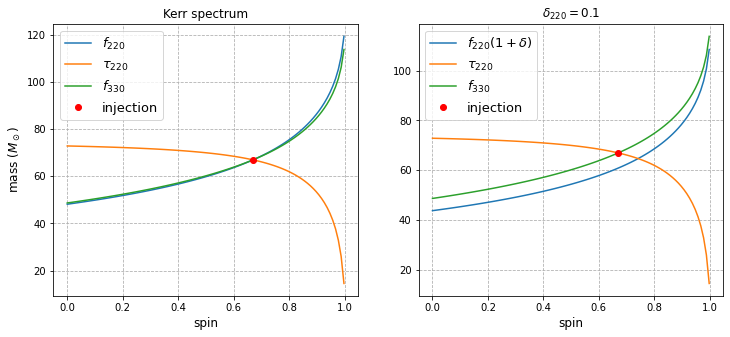

In [68]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

## GR example
mode1 = (2,2,0)
mode2 = (3,3,0)
i = modes.index(mode1)
masses, spins = invert_qnm_from_f(freqs[i],mode1)
axs[0].plot(spins,masses,label='$f_{220}$')
masses, spins = invert_qnm_from_tau(taus[i],mode1)
axs[0].plot(spins,masses,label='$\\tau_{220}$')
i = modes.index(mode2)
masses, spins = invert_qnm_from_f(freqs[i],mode2)
axs[0].plot(spins,masses,label='$f_{330}$')
axs[0].plot(spin_f,mass_f,'o',color='red',label='injection')
axs[0].set_xlabel('spin',fontsize=12)
axs[0].set_ylabel('mass $(M_\odot)$',fontsize=12)
axs[0].grid(linestyle='--')
axs[0].legend(fontsize=13)
axs[0].set_title('Kerr spectrum',fontsize=12)

## non-GR example
i = modes.index(mode1)
delta = 0.1
masses, spins = invert_qnm_from_f(freqs[i]*(1+delta),mode1)
axs[1].plot(spins,masses,label='$f_{220}(1+\delta)$')
masses, spins = invert_qnm_from_tau(taus[i],mode1)
axs[1].plot(spins,masses,label='$\\tau_{220}$')
i = modes.index(mode2)
masses, spins = invert_qnm_from_f(freqs[i],mode2)
axs[1].plot(spins,masses,label='$f_{330}$')
axs[1].plot(spin_f,mass_f,'o',color='red',label='injection')
axs[1].set_xlabel('spin',fontsize=12)
#axs[1].set_ylabel('mass',fontsize=12)
axs[1].grid(linestyle='--')
axs[1].legend(fontsize=13)
axs[1].set_title('$\delta_{220}=0.1$',fontsize=12)
plt.show()

In reality, frequencies and damping times have uncertainties. Therefore, instead of plotting single lines, you want to plot bands that bracket the uncertainty over each quantity. In the plots below, we repeat the previous exercise but we plot $2\sigma$ intervals for each quantity. 

_For simplicity, in the non-Kerr spectrum, we use the same $1\sigma$ errors computed above for the Kerr case. We should have recomputed the Fisher matrix with the new value of $f_{220}$. However, this straightforward refinement would just introduce a small quantitative correction without affecting our overall conclusion._

__Note: Large uncertainties over $\tau$ can produce unphysical negative values of $\tau$ at lower extreme of its distributions. The function `invert_qnm_from_tau` will still invert negative $\tau$'s for any spin by yelding negative masses. In this case, you simply cut negative masses out from the mass-spin diagram.__

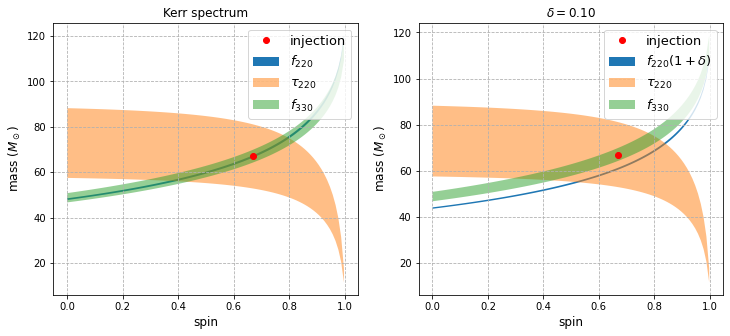

In [71]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
## GR example
mode1 = (2,2,0)
mode2 = (3,3,0)
i = modes.index(mode1)
fp, fm = freqs[i]+2*sigmas[mode1][0], freqs[i]-2*sigmas[mode1][0]
masses1, spins = invert_qnm_from_f(fp,mode1)
masses2, _ = invert_qnm_from_f(fm,mode1)
axs[0].fill_between(spins,masses1,masses2,label='$f_{220}$')
tp, tm = taus[i]+2*sigmas[mode1][1], taus[i]-2*sigmas[mode1][1]
masses1, spins = invert_qnm_from_tau(tp,mode1)
masses2, _ = invert_qnm_from_tau(tm,mode1)
axs[0].fill_between(spins,masses1,masses2,label='$\\tau_{220}$',\
                    alpha=0.5)
i = modes.index(mode2)
fp, fm = freqs[i]+2*sigmas[mode2][0], freqs[i]-2*sigmas[mode2][0]
masses1, spins = invert_qnm_from_f(fp,mode2)
masses2, _ = invert_qnm_from_f(fm,mode2)
axs[0].fill_between(spins,masses1,masses2,label='$f_{330}$',alpha=0.5)
axs[0].plot(spin_f,mass_f,'o',color='red',label='injection')
axs[0].set_xlabel('spin',fontsize=12)
axs[0].set_ylabel('mass $(M_\odot)$',fontsize=12)
axs[0].grid(linestyle='--')
axs[0].legend(fontsize=13)
axs[0].set_title('Kerr spectrum',fontsize=12)
## non-GR example
i = modes.index(mode1)
delta = 0.1
fp, fm = freqs[i]*(1+delta)+2*sigmas[mode1][0],\
    freqs[i]*(1+delta)-2*sigmas[mode1][0]
masses1, spins = invert_qnm_from_f(fp,mode1)
masses2, _ = invert_qnm_from_f(fm,mode1)
axs[1].fill_between(spins,masses1,masses2,label='$f_{220}(1+\delta)$')
tp, tm = taus[i]+2*sigmas[mode1][1], taus[i]-2*sigmas[mode1][1]
masses1, spins = invert_qnm_from_tau(tp,mode1)
masses2, _ = invert_qnm_from_tau(tm,mode1)
axs[1].fill_between(spins,masses1,masses2,label='$\\tau_{220}$',alpha=0.5)
i = modes.index(mode2)
fp, fm = freqs[i]+2*sigmas[mode2][0], freqs[i]-2*sigmas[mode2][0]
masses1, spins = invert_qnm_from_f(fp,mode2)
masses2, _ = invert_qnm_from_f(fm,mode2)
axs[1].fill_between(spins,masses1,masses2,label='$f_{330}$',alpha=0.5)
axs[1].plot(spin_f,mass_f,'o',color='red',label='injection')
axs[1].set_xlabel('spin',fontsize=12)
axs[1].set_ylabel('mass $(M_\odot)$',fontsize=12)
axs[1].grid(linestyle='--')
axs[1].legend(fontsize=13)
axs[1].set_title('$\delta=%.2f$'%delta,fontsize=12)
plt.show()